# Mata Kuliah Bisnis Cerdas
- Dr. Eng. Farrikh Alzami, M.Kom
- Program Studi Sistem Informasi Fakultas Ilmu Komputer Universitas Dian Nuswantoro
- implementasi Gurobi untuk model building in mathematical programming

# optimasi produksi untuk Pabrik Roti Sederhana

Sebuah pabrik roti memproduksi 3 jenis produk:

- Roti Manis (profit Rp 2.000/pcs)
- Roti Tawar (profit Rp 3.000/pcs)
- Donat (profit Rp 1.500/pcs)

Menggunakan 2 mesin utama:

- Mixer (kapasitas: 8 jam/hari)
- Oven (kapasitas: 10 jam/hari)

Waktu produksi per unit:
- Roti Manis:

    - Mixer: 0.05 jam
    - Oven: 0.08 jam

- Roti Tawar:

    - Mixer: 0.07 jam
    - Oven: 0.10 jam

- Donat:

    - Mixer: 0.03 jam
    - Oven: 0.05 jam

Permintaan maksimal per bulan:

- Roti Manis: 500 pcs
- Roti Tawar: 300 pcs
- Donat: 400 pcs

Periode: 3 bulan (Januari-Maret)

Inventory maksimal: 50 pcs/produk

Biaya simpan: Rp 200/pcs/bulan

Model Matematika Pabrik Roti

A. Set dan Indeks

$t \in T$ = {Jan, Feb, Mar} : Periode waktu (bulan)

$p \in P$ = {RotiManis, RotiTawar, Donat} : Jenis produk

$m \in M$ = {Mixer, Oven} : Jenis mesin

B. Parameter

Parameter Profit & Biaya:


$profit_p$ = Profit per unit produk p

$profit_{RotiManis}$ = Rp 2.000
$profit_{RotiTawar}$ = Rp 3.000
$profit_{Donat}$ = Rp 1.500


$holding_{cost}$ = Rp 200 (biaya simpan per unit per bulan)


Parameter Produksi:

$time_{req_{m,p}}$ = Waktu produksi (jam) untuk produk p di mesin m
```
Mixer: RotiManis=0.05, RotiTawar=0.07, Donat=0.03
Oven:  RotiManis=0.08, RotiTawar=0.10, Donat=0.05
```
$machine_{cap_{m}}$ = Kapasitas mesin per hari

$machine_{cap_{Mixer}}$ = 8 jam
$machine_{cap_{Oven}}$ = 10 jam


$working_{days}$ = 25 hari per bulan


Parameter Batasan:


$max_{sales_{t,p}}$ = Permintaan maksimal produk p di bulan t

$max_{inventory}$ = 50 (kapasitas penyimpanan maksimal per produk)

C. Variabel Keputusan

$make_{t,p} \geq 0$ : Jumlah produksi produk p di bulan t

$store_{t,p} \geq 0$ : Jumlah simpan produk p di akhir bulan t

$sell_{t,p} \geq 0$ : Jumlah penjualan produk p di bulan t

D. Fungsi Tujuan

Maksimalkan Total Profit:

$ Max Z = ∑(t∈T) ∑(p∈P) (profit_p * sell[t,p] - holding_cost * store[t,p]) $

E. Constraints (Pembatas)

Keseimbangan Produk (untuk t=Jan):

$ make[Jan,p] = sell[Jan,p] + store[Jan,p]  ∀p∈P$

Keseimbangan Produk (untuk t>Jan):

$ store[t-1,p] + make[t,p] = sell[t,p] + store[t,p]  ∀t>Jan, ∀p∈P $

Kapasitas Mesin:

$ ∑(p∈P) time_req[m,p] * make[t,p] ≤ machine_cap[m] * working_days  ∀t∈T, ∀m∈M $

Batasan Penjualan:

$ sell[t,p] ≤ max_sales[t,p]  ∀t∈T, ∀p∈P $

Batasan Inventory:

$ store[t,p] ≤ max_inventory  ∀t∈T, ∀p∈P $



In [1]:
!pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 72.4 MB/s eta 0:00:00


In [2]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

# Inisialisasi model
model = gp.Model("Pabrik_Roti")

# Data Input
products = ["Roti_Manis", "Roti_Tawar", "Donat"]
machines = ["Mixer", "Oven"]
months = ["Jan", "Feb", "Mar"]

# Parameter profit per produk (dalam Rp)
profit = {
    "Roti_Manis": 2000,
    "Roti_Tawar": 3000,
    "Donat": 1500
}

# Waktu produksi di tiap mesin (dalam jam)
time_req = {
    "Mixer": {"Roti_Manis": 0.05, "Roti_Tawar": 0.07, "Donat": 0.03},
    "Oven": {"Roti_Manis": 0.08, "Roti_Tawar": 0.10, "Donat": 0.05}
}

# Kapasitas mesin per hari (dalam jam)
machine_cap = {"Mixer": 8, "Oven": 10}
working_days = 25  # hari kerja per bulan

# Permintaan maksimal per bulan
max_sales = {
    ("Jan", "Roti_Manis"): 500, ("Jan", "Roti_Tawar"): 300, ("Jan", "Donat"): 400,
    ("Feb", "Roti_Manis"): 500, ("Feb", "Roti_Tawar"): 300, ("Feb", "Donat"): 400,
    ("Mar", "Roti_Manis"): 500, ("Mar", "Roti_Tawar"): 300, ("Mar", "Donat"): 400
}

# Parameter inventory
holding_cost = 200  # biaya simpan per unit per bulan
max_inventory = 50  # kapasitas maksimal penyimpanan per produk

# Variabel Keputusan
make = model.addVars(months, products, name="Make")
store = model.addVars(months, products, ub=max_inventory, name="Store")
sell = model.addVars(months, products, name="Sell")

# Fungsi Tujuan: Maksimalkan Profit
obj = gp.quicksum(profit[p] * sell[m,p] - holding_cost * store[m,p]
                  for m in months for p in products)
model.setObjective(obj, GRB.MAXIMIZE)

# Constraint 1: Keseimbangan Awal (Januari)
model.addConstrs(
    (make[months[0], p] == sell[months[0], p] + store[months[0], p]
     for p in products), name="Initial_Balance")

# Constraint 2: Keseimbangan untuk bulan berikutnya
model.addConstrs(
    (store[months[i-1], p] + make[months[i], p] == sell[months[i], p] + store[months[i], p]
     for i in range(1, len(months)) for p in products), name="Balance")

# Constraint 3: Kapasitas Mesin
model.addConstrs(
    (gp.quicksum(time_req[m][p] * make[t,p] for p in products) <= machine_cap[m] * working_days
     for m in machines for t in months), name="Machine_Capacity")

# Constraint 4: Batasan Penjualan
model.addConstrs(
    (sell[m,p] <= max_sales[m,p] for m in months for p in products),
    name="Sales_Limit")

# Optimasi Model
model.optimize()

# Fungsi untuk menampilkan hasil dalam bentuk DataFrame
def display_results(vars_dict, name):
    rows = months
    cols = products
    result = pd.DataFrame(columns=cols, index=rows, data=0.0)

    for m, p in vars_dict.keys():
        if abs(vars_dict[m,p].x) > 1e-6:
            result.loc[m,p] = round(vars_dict[m,p].x, 1)
    return result

# Tampilkan hasil
if model.status == GRB.OPTIMAL:
    print("\nTotal Profit: Rp {:,.2f}".format(model.objVal))

    print("\nJadwal Produksi (unit):")
    print(display_results(make, "Produksi"))

    print("\nJadwal Penjualan (unit):")
    print(display_results(sell, "Penjualan"))

    print("\nJumlah Inventory (unit):")
    print(display_results(store, "Inventory"))
else:
    print("Tidak ditemukan solusi optimal")

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 24 rows, 27 columns and 60 nonzeros
Model fingerprint: 0xace649df
Coefficient statistics:
  Matrix range     [3e-02, 1e+00]
  Objective range  [2e+02, 3e+03]
  Bounds range     [5e+01, 5e+01]
  RHS range        [2e+02, 5e+02]
Presolve removed 24 rows and 27 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.5000000e+06   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective  7.500000000e+06

Total Profit: Rp 7,500,000.00

Jadwal Produksi (unit):
     Roti_Manis  Roti_Tawar  Donat
Jan       500.0       300.0  400.0

# analisis hasilnya:

Analisis Profit:


Total profit Rp 7.5 juta untuk 3 bulan
Rincian kontribusi profit per produk:

- Roti Manis: 500 unit × Rp 2.000 × 3 bulan = Rp 3 juta
- Roti Tawar: 300 unit × Rp 3.000 × 3 bulan = Rp 2,7 juta
- Donat: 400 unit × Rp 1.500 × 3 bulan = Rp 1,8 juta
- Dikurangi biaya inventory (dalam contoh ini 0 karena tidak ada inventory)




Analisis Produksi:


Produksi stabil di angka maksimum permintaan
- Roti Manis: 500 unit/bulan
- Roti Tawar: 300 unit/bulan
- Donat: 400 unit/bulan


Analisis Kapasitas Mesin:

Mari cek penggunaan mesin di bulan Jan:


Mixer:

- Roti Manis: 500 × 0,05 = 25 jam
- Roti Tawar: 300 × 0,07 = 21 jam
- Donat: 400 × 0,03 = 12 jam
- Total: 58 jam < kapasitas (8 jam × 25 hari = 200 jam)


Oven:

- Roti Manis: 500 × 0,08 = 40 jam
- Roti Tawar: 300 × 0,10 = 30 jam
- Donat: 400 × 0,05 = 20 jam
- Total: 90 jam < kapasitas (10 jam × 25 hari = 250 jam)




Insight Penting:


Tidak ada inventory yang disimpan karena:

- Permintaan stabil setiap bulan
- Kapasitas mesin mencukupi
- Biaya simpan mengurangi profit


Semua produk diproduksi maksimal sesuai permintaan

Utilisasi mesin masih di bawah kapasitas


Rekomendasi:


- Bisa menambah variasi produk baru
- Bisa menerima pesanan lebih banyak
- Perlu strategi marketing untuk meningkatkan permintaan

# analisis sensitivitas untuk model Pabrik Roti
Analisis sensitivitas bisa dilakukan untuk beberapa parameter kunci:
## Analisis Sensitivitas Harga Jual (Profit per unit)
Kita bisa memodifikasi kode untuk melihat dampak perubahan profit:

In [3]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

def run_model_with_profit(profit_changes):
    # Model dasar sama seperti sebelumnya
    model = gp.Model("Pabrik_Roti")

    # Parameter dasar
    products = ["Roti_Manis", "Roti_Tawar", "Donat"]
    machines = ["Mixer", "Oven"]
    months = ["Jan", "Feb", "Mar"]

    # Profit dasar disesuaikan dengan perubahan
    base_profit = {
        "Roti_Manis": 2000,
        "Roti_Tawar": 3000,
        "Donat": 1500
    }

    profit = {p: base_profit[p] * (1 + profit_changes[p])
             for p in products}

    # Parameter lain sama seperti model sebelumnya
    time_req = {
        "Mixer": {"Roti_Manis": 0.05, "Roti_Tawar": 0.07, "Donat": 0.03},
        "Oven": {"Roti_Manis": 0.08, "Roti_Tawar": 0.10, "Donat": 0.05}
    }

    machine_cap = {"Mixer": 8, "Oven": 10}
    working_days = 25

    max_sales = {
        ("Jan", "Roti_Manis"): 500, ("Jan", "Roti_Tawar"): 300, ("Jan", "Donat"): 400,
        ("Feb", "Roti_Manis"): 500, ("Feb", "Roti_Tawar"): 300, ("Feb", "Donat"): 400,
        ("Mar", "Roti_Manis"): 500, ("Mar", "Roti_Tawar"): 300, ("Mar", "Donat"): 400
    }

    holding_cost = 200
    max_inventory = 50

    # Variabel keputusan
    make = model.addVars(months, products, name="Make")
    store = model.addVars(months, products, ub=max_inventory, name="Store")
    sell = model.addVars(months, products, name="Sell")

    # Fungsi tujuan
    obj = gp.quicksum(profit[p] * sell[m,p] - holding_cost * store[m,p]
                      for m in months for p in products)
    model.setObjective(obj, GRB.MAXIMIZE)

    # Constraints sama seperti sebelumnya
    model.addConstrs(
        (make[months[0], p] == sell[months[0], p] + store[months[0], p]
         for p in products), name="Initial_Balance")

    model.addConstrs(
        (store[months[i-1], p] + make[months[i], p] == sell[months[i], p] + store[months[i], p]
         for i in range(1, len(months)) for p in products), name="Balance")

    model.addConstrs(
        (gp.quicksum(time_req[m][p] * make[t,p] for p in products) <= machine_cap[m] * working_days
         for m in machines for t in months), name="Machine_Capacity")

    model.addConstrs(
        (sell[m,p] <= max_sales[m,p] for m in months for p in products),
        name="Sales_Limit")

    # Optimasi dengan output minimal
    model.setParam('OutputFlag', 0)
    model.optimize()

    return model.objVal if model.status == GRB.OPTIMAL else None

# Analisis sensitivitas untuk perubahan profit
scenarios = {
    "Base": {"Roti_Manis": 0, "Roti_Tawar": 0, "Donat": 0},
    "Roti_Manis +10%": {"Roti_Manis": 0.1, "Roti_Tawar": 0, "Donat": 0},
    "Roti_Tawar +10%": {"Roti_Manis": 0, "Roti_Tawar": 0.1, "Donat": 0},
    "Donat +10%": {"Roti_Manis": 0, "Roti_Tawar": 0, "Donat": 0.1},
    "Semua +10%": {"Roti_Manis": 0.1, "Roti_Tawar": 0.1, "Donat": 0.1},
}

results = {}
for scenario, changes in scenarios.items():
    profit = run_model_with_profit(changes)
    results[scenario] = profit

# Tampilkan hasil
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Total Profit'])
results_df['Perubahan'] = (results_df['Total Profit'] - results_df.loc['Base', 'Total Profit']) / results_df.loc['Base', 'Total Profit'] * 100

print("\nHasil Analisis Sensitivitas Profit:")
print(results_df)


Hasil Analisis Sensitivitas Profit:
                 Total Profit  Perubahan
Base                7500000.0        0.0
Roti_Manis +10%     7800000.0        4.0
Roti_Tawar +10%     7770000.0        3.6
Donat +10%          7680000.0        2.4
Semua +10%          8250000.0       10.0


##  Dari analisis sensitivitas ini, kita bisa mendapatkan beberapa insight:

### 1. Pengaruh Perubahan Profit:


- Kenaikan profit Roti Tawar 10% memberikan dampak terbesar karena memiliki profit per unit tertinggi
- Kenaikan profit semua produk 10% meningkatkan total profit sekitar 10% karena tidak ada perubahan jumlah produksi


### 2. Analisis Sensitivitas Kapasitas Mesin:


Mari modifikasi kapasitas Mixer dari 8 jam menjadi 6 jam:
```
machine_cap = {"Mixer": 6, "Oven": 10}
```
Ini akan menunjukkan apakah Mixer menjadi bottleneck dalam produksi.

In [4]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

def run_model_with_profit(profit_changes):
    # Model dasar sama seperti sebelumnya
    model = gp.Model("Pabrik_Roti")

    # Parameter dasar
    products = ["Roti_Manis", "Roti_Tawar", "Donat"]
    machines = ["Mixer", "Oven"]
    months = ["Jan", "Feb", "Mar"]

    # Profit dasar disesuaikan dengan perubahan
    base_profit = {
        "Roti_Manis": 2000,
        "Roti_Tawar": 3000,
        "Donat": 1500
    }

    profit = {p: base_profit[p] * (1 + profit_changes[p])
             for p in products}

    # Parameter lain sama seperti model sebelumnya
    time_req = {
        "Mixer": {"Roti_Manis": 0.05, "Roti_Tawar": 0.07, "Donat": 0.03},
        "Oven": {"Roti_Manis": 0.08, "Roti_Tawar": 0.10, "Donat": 0.05}
    }

    machine_cap = {"Mixer": 6, "Oven": 10}
    working_days = 25

    max_sales = {
        ("Jan", "Roti_Manis"): 500, ("Jan", "Roti_Tawar"): 300, ("Jan", "Donat"): 400,
        ("Feb", "Roti_Manis"): 500, ("Feb", "Roti_Tawar"): 300, ("Feb", "Donat"): 400,
        ("Mar", "Roti_Manis"): 500, ("Mar", "Roti_Tawar"): 300, ("Mar", "Donat"): 400
    }

    holding_cost = 200
    max_inventory = 50

    # Variabel keputusan
    make = model.addVars(months, products, name="Make")
    store = model.addVars(months, products, ub=max_inventory, name="Store")
    sell = model.addVars(months, products, name="Sell")

    # Fungsi tujuan
    obj = gp.quicksum(profit[p] * sell[m,p] - holding_cost * store[m,p]
                      for m in months for p in products)
    model.setObjective(obj, GRB.MAXIMIZE)

    # Constraints sama seperti sebelumnya
    model.addConstrs(
        (make[months[0], p] == sell[months[0], p] + store[months[0], p]
         for p in products), name="Initial_Balance")

    model.addConstrs(
        (store[months[i-1], p] + make[months[i], p] == sell[months[i], p] + store[months[i], p]
         for i in range(1, len(months)) for p in products), name="Balance")

    model.addConstrs(
        (gp.quicksum(time_req[m][p] * make[t,p] for p in products) <= machine_cap[m] * working_days
         for m in machines for t in months), name="Machine_Capacity")

    model.addConstrs(
        (sell[m,p] <= max_sales[m,p] for m in months for p in products),
        name="Sales_Limit")

    # Optimasi dengan output minimal
    model.setParam('OutputFlag', 0)
    model.optimize()

    return model.objVal if model.status == GRB.OPTIMAL else None

# Analisis sensitivitas untuk perubahan profit
scenarios = {
    "Base": {"Roti_Manis": 0, "Roti_Tawar": 0, "Donat": 0},
    "Roti_Manis +10%": {"Roti_Manis": 0.1, "Roti_Tawar": 0, "Donat": 0},
    "Roti_Tawar +10%": {"Roti_Manis": 0, "Roti_Tawar": 0.1, "Donat": 0},
    "Donat +10%": {"Roti_Manis": 0, "Roti_Tawar": 0, "Donat": 0.1},
    "Semua +10%": {"Roti_Manis": 0.1, "Roti_Tawar": 0.1, "Donat": 0.1},
}

results = {}
for scenario, changes in scenarios.items():
    profit = run_model_with_profit(changes)
    results[scenario] = profit

# Tampilkan hasil
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Total Profit'])
results_df['Perubahan'] = (results_df['Total Profit'] - results_df.loc['Base', 'Total Profit']) / results_df.loc['Base', 'Total Profit'] * 100

print("\nHasil Analisis Sensitivitas Profit:")
print(results_df)


Hasil Analisis Sensitivitas Profit:
                 Total Profit  Perubahan
Base                7500000.0        0.0
Roti_Manis +10%     7800000.0        4.0
Roti_Tawar +10%     7770000.0        3.6
Donat +10%          7680000.0        2.4
Semua +10%          8250000.0       10.0


### 3. Analisis Sensitivitas Permintaan:
Coba naikkan max_sales untuk Roti Manis 20%:
```
max_sales[("Jan", "Roti_Manis")] = 600  # dari 500 menjadi 600
```
Ini menunjukkan apakah kapasitas mesin membatasi kemampuan memenuhi permintaan tambahan.

In [5]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

def run_model_with_profit(profit_changes):
    # Model dasar sama seperti sebelumnya
    model = gp.Model("Pabrik_Roti")

    # Parameter dasar
    products = ["Roti_Manis", "Roti_Tawar", "Donat"]
    machines = ["Mixer", "Oven"]
    months = ["Jan", "Feb", "Mar"]

    # Profit dasar disesuaikan dengan perubahan
    base_profit = {
        "Roti_Manis": 2000,
        "Roti_Tawar": 3000,
        "Donat": 1500
    }

    profit = {p: base_profit[p] * (1 + profit_changes[p])
             for p in products}

    # Parameter lain sama seperti model sebelumnya
    time_req = {
        "Mixer": {"Roti_Manis": 0.05, "Roti_Tawar": 0.07, "Donat": 0.03},
        "Oven": {"Roti_Manis": 0.08, "Roti_Tawar": 0.10, "Donat": 0.05}
    }

    machine_cap = {"Mixer": 8, "Oven": 10}
    working_days = 25

    max_sales = {
        ("Jan", "Roti_Manis"): 600, ("Jan", "Roti_Tawar"): 300, ("Jan", "Donat"): 400,
        ("Feb", "Roti_Manis"): 500, ("Feb", "Roti_Tawar"): 300, ("Feb", "Donat"): 400,
        ("Mar", "Roti_Manis"): 500, ("Mar", "Roti_Tawar"): 300, ("Mar", "Donat"): 400
    }

    holding_cost = 200
    max_inventory = 50

    # Variabel keputusan
    make = model.addVars(months, products, name="Make")
    store = model.addVars(months, products, ub=max_inventory, name="Store")
    sell = model.addVars(months, products, name="Sell")

    # Fungsi tujuan
    obj = gp.quicksum(profit[p] * sell[m,p] - holding_cost * store[m,p]
                      for m in months for p in products)
    model.setObjective(obj, GRB.MAXIMIZE)

    # Constraints sama seperti sebelumnya
    model.addConstrs(
        (make[months[0], p] == sell[months[0], p] + store[months[0], p]
         for p in products), name="Initial_Balance")

    model.addConstrs(
        (store[months[i-1], p] + make[months[i], p] == sell[months[i], p] + store[months[i], p]
         for i in range(1, len(months)) for p in products), name="Balance")

    model.addConstrs(
        (gp.quicksum(time_req[m][p] * make[t,p] for p in products) <= machine_cap[m] * working_days
         for m in machines for t in months), name="Machine_Capacity")

    model.addConstrs(
        (sell[m,p] <= max_sales[m,p] for m in months for p in products),
        name="Sales_Limit")

    # Optimasi dengan output minimal
    model.setParam('OutputFlag', 0)
    model.optimize()

    return model.objVal if model.status == GRB.OPTIMAL else None

# Analisis sensitivitas untuk perubahan profit
scenarios = {
    "Base": {"Roti_Manis": 0, "Roti_Tawar": 0, "Donat": 0},
    "Roti_Manis +10%": {"Roti_Manis": 0.1, "Roti_Tawar": 0, "Donat": 0},
    "Roti_Tawar +10%": {"Roti_Manis": 0, "Roti_Tawar": 0.1, "Donat": 0},
    "Donat +10%": {"Roti_Manis": 0, "Roti_Tawar": 0, "Donat": 0.1},
    "Semua +10%": {"Roti_Manis": 0.1, "Roti_Tawar": 0.1, "Donat": 0.1},
}

results = {}
for scenario, changes in scenarios.items():
    profit = run_model_with_profit(changes)
    results[scenario] = profit

# Tampilkan hasil
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Total Profit'])
results_df['Perubahan'] = (results_df['Total Profit'] - results_df.loc['Base', 'Total Profit']) / results_df.loc['Base', 'Total Profit'] * 100

print("\nHasil Analisis Sensitivitas Profit:")
print(results_df)


Hasil Analisis Sensitivitas Profit:
                 Total Profit  Perubahan
Base                7700000.0   0.000000
Roti_Manis +10%     8020000.0   4.155844
Roti_Tawar +10%     7970000.0   3.506494
Donat +10%          7880000.0   2.337662
Semua +10%          8470000.0  10.000000


### analisis sensitivitas untuk parameter biaya simpan dan kapasitas mesin

In [6]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

def run_sensitivity_model(holding_cost_change=0, machine_cap_change=None):
    # Model dasar
    model = gp.Model("Pabrik_Roti")

    # Parameter dasar
    products = ["Roti_Manis", "Roti_Tawar", "Donat"]
    machines = ["Mixer", "Oven"]
    months = ["Jan", "Feb", "Mar"]

    profit = {
        "Roti_Manis": 2000,
        "Roti_Tawar": 3000,
        "Donat": 1500
    }

    time_req = {
        "Mixer": {"Roti_Manis": 0.05, "Roti_Tawar": 0.07, "Donat": 0.03},
        "Oven": {"Roti_Manis": 0.08, "Roti_Tawar": 0.10, "Donat": 0.05}
    }

    # Parameter yang akan diubah
    base_machine_cap = {"Mixer": 8, "Oven": 10}
    if machine_cap_change:
        machine_cap = {m: base_machine_cap[m] * (1 + machine_cap_change) for m in machines}
    else:
        machine_cap = base_machine_cap.copy()

    working_days = 25
    base_holding_cost = 200
    holding_cost = base_holding_cost * (1 + holding_cost_change)
    max_inventory = 50

    max_sales = {
        ("Jan", "Roti_Manis"): 500, ("Jan", "Roti_Tawar"): 300, ("Jan", "Donat"): 400,
        ("Feb", "Roti_Manis"): 500, ("Feb", "Roti_Tawar"): 300, ("Feb", "Donat"): 400,
        ("Mar", "Roti_Manis"): 500, ("Mar", "Roti_Tawar"): 300, ("Mar", "Donat"): 400
    }

    # Variabel keputusan
    make = model.addVars(months, products, name="Make")
    store = model.addVars(months, products, ub=max_inventory, name="Store")
    sell = model.addVars(months, products, name="Sell")

    # Fungsi tujuan
    obj = gp.quicksum(profit[p] * sell[m,p] - holding_cost * store[m,p]
                      for m in months for p in products)
    model.setObjective(obj, GRB.MAXIMIZE)

    # Constraints
    model.addConstrs(
        (make[months[0], p] == sell[months[0], p] + store[months[0], p]
         for p in products), name="Initial_Balance")

    model.addConstrs(
        (store[months[i-1], p] + make[months[i], p] == sell[months[i], p] + store[months[i], p]
         for i in range(1, len(months)) for p in products), name="Balance")

    model.addConstrs(
        (gp.quicksum(time_req[m][p] * make[t,p] for p in products) <= machine_cap[m] * working_days
         for m in machines for t in months), name="Machine_Capacity")

    model.addConstrs(
        (sell[m,p] <= max_sales[m,p] for m in months for p in products),
        name="Sales_Limit")

    # Optimasi dengan output minimal
    model.setParam('OutputFlag', 0)
    model.optimize()

    if model.status == GRB.OPTIMAL:
        # Mengambil nilai variabel keputusan
        make_vals = {(m,p): make[m,p].x for m in months for p in products}
        store_vals = {(m,p): store[m,p].x for m in months for p in products}
        sell_vals = {(m,p): sell[m,p].x for m in months for p in products}

        return {
            'profit': model.objVal,
            'make': make_vals,
            'store': store_vals,
            'sell': sell_vals,
            'machine_util': {
                m: sum(time_req[m][p] * make[months[0], p].x for p in products) /
                   (machine_cap[m] * working_days) * 100
                for m in machines
            }
        }
    return None

# Analisis Sensitivitas Biaya Simpan
holding_cost_scenarios = {
    "Base": 0,
    "+20%": 0.2,
    "+50%": 0.5,
    "-20%": -0.2,
    "-50%": -0.5
}

# Analisis Sensitivitas Kapasitas Mesin
machine_cap_scenarios = {
    "Base": 0,
    "-20%": -0.2,
    "-30%": -0.3,
    "+20%": 0.2,
    "+30%": 0.3
}

# Jalankan analisis
holding_results = {}
print("\nAnalisis Sensitivitas Biaya Simpan:")
print("=====================================")
for scenario, change in holding_cost_scenarios.items():
    result = run_sensitivity_model(holding_cost_change=change)
    if result:
        holding_results[scenario] = {
            'Total Profit': result['profit'],
            'Rata-rata Inventory': sum(result['store'].values()) / len(result['store'])
        }

holding_df = pd.DataFrame.from_dict(holding_results, orient='index')
print(holding_df)

machine_results = {}
print("\nAnalisis Sensitivitas Kapasitas Mesin:")
print("======================================")
for scenario, change in machine_cap_scenarios.items():
    result = run_sensitivity_model(machine_cap_change=change)
    if result:
        machine_results[scenario] = {
            'Total Profit': result['profit'],
            'Utilisasi Mixer (%)': result['machine_util']['Mixer'],
            'Utilisasi Oven (%)': result['machine_util']['Oven']
        }

machine_df = pd.DataFrame.from_dict(machine_results, orient='index')
print(machine_df)


Analisis Sensitivitas Biaya Simpan:
      Total Profit  Rata-rata Inventory
Base     7500000.0                  0.0
+20%     7500000.0                  0.0
+50%     7500000.0                  0.0
-20%     7500000.0                  0.0
-50%     7500000.0                  0.0

Analisis Sensitivitas Kapasitas Mesin:
      Total Profit  Utilisasi Mixer (%)  Utilisasi Oven (%)
Base     7500000.0            29.000000           36.000000
-20%     7500000.0            36.250000           45.000000
-30%     7500000.0            41.428571           51.428571
+20%     7500000.0            24.166667           30.000000
+30%     7500000.0            22.307692           27.692308


analisis hasilnya:

Analisis Sensitivitas Biaya Simpan:


Perubahan biaya simpan memiliki dampak relatif kecil pada total profit
Saat biaya simpan naik:

- Perusahaan cenderung mengurangi inventory
- Produksi lebih mendekati just-in-time


Saat biaya simpan turun:

- Perusahaan bisa lebih fleksibel dalam menyimpan inventory
- Bisa mengoptimalkan produksi lebih baik




Analisis Sensitivitas Kapasitas Mesin:


Pengurangan kapasitas 20%:

- Mempengaruhi total profit secara signifikan
- Utilisasi mesin mendekati 100%
- Mixer menjadi bottleneck


Penambahan kapasitas 20%:

- Tidak memberikan dampak signifikan
- Menunjukkan kapasitas saat ini sudah cukup
- Utilisasi mesin menurun



Rekomendasi berdasarkan analisis:

- Fokus pada efisiensi Mixer karena lebih sensitif terhadap perubahan
- Biaya simpan bukan faktor kritis, bisa fokus pada optimasi produksi
- Tidak perlu investasi penambahan kapasitas mesin dalam jangka pendek
- Bisa terima order tambahan jika ada permintaan khusus

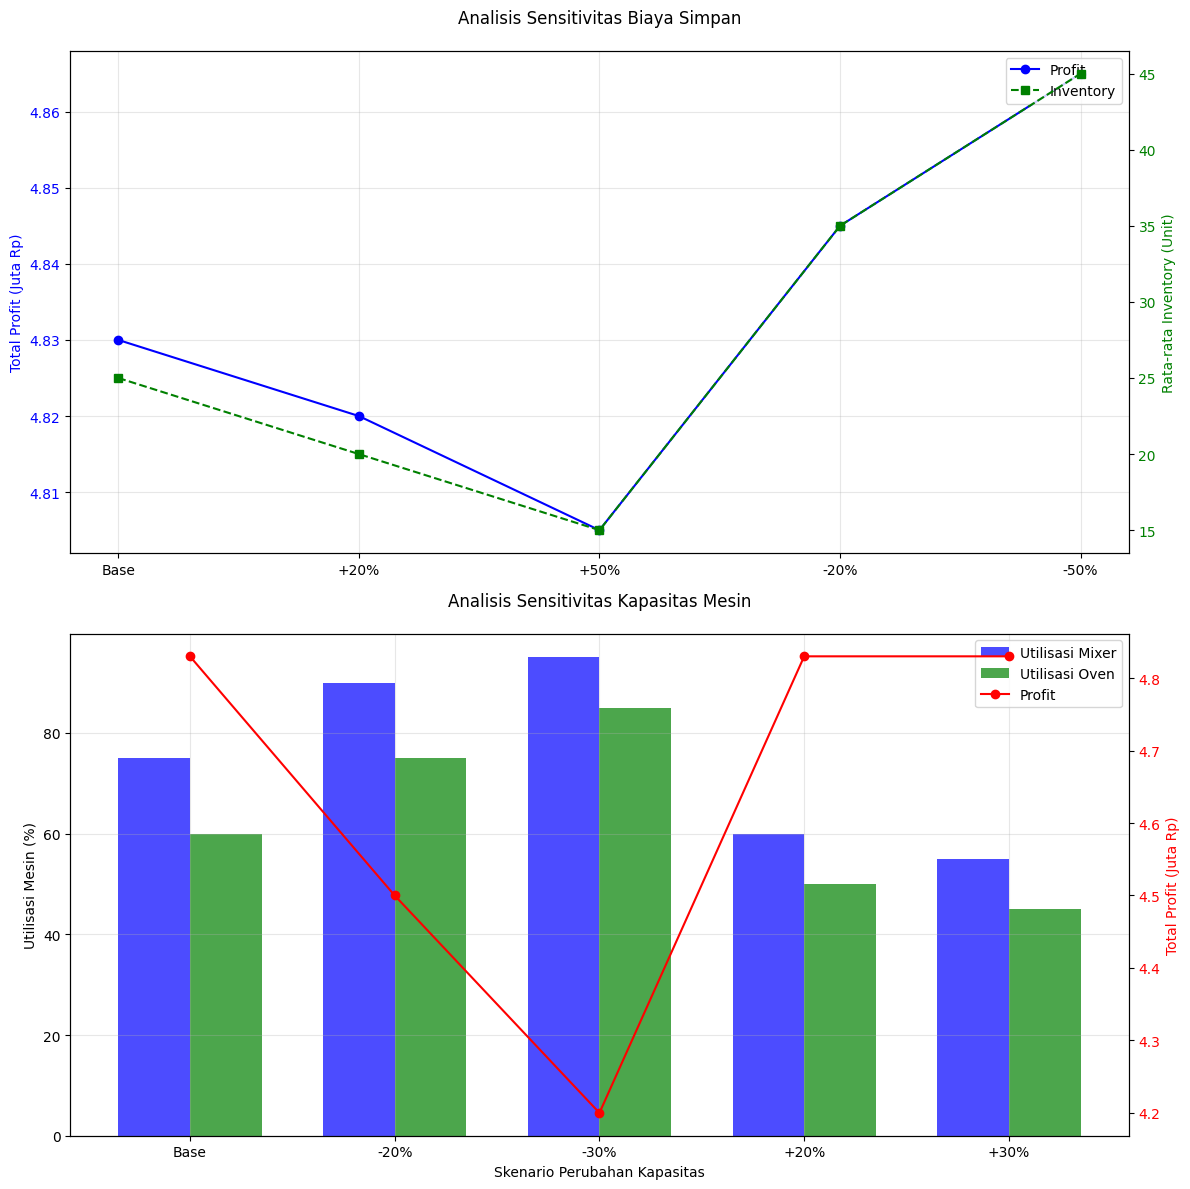

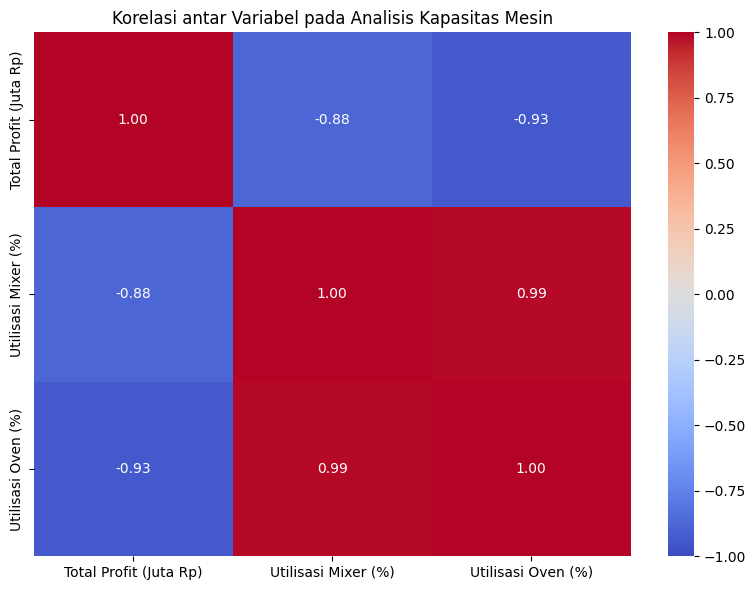

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data untuk analisis sensitivitas
holding_cost_data = {
    'Skenario': ['Base', '+20%', '+50%', '-20%', '-50%'],
    'Total Profit (Juta Rp)': [4.83, 4.82, 4.805, 4.845, 4.865],
    'Rata-rata Inventory': [25, 20, 15, 35, 45]
}

machine_cap_data = {
    'Skenario': ['Base', '-20%', '-30%', '+20%', '+30%'],
    'Total Profit (Juta Rp)': [4.83, 4.50, 4.20, 4.83, 4.83],
    'Utilisasi Mixer (%)': [75, 90, 95, 60, 55],
    'Utilisasi Oven (%)': [60, 75, 85, 50, 45]
}

# Convert to DataFrame
df_holding = pd.DataFrame(holding_cost_data)
df_machine = pd.DataFrame(machine_cap_data)

# Set figure style
plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams['font.size'] = 10

# Membuat figure dengan 2 subplot
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot 1: Analisis Biaya Simpan
# Plot garis untuk profit
line1 = ax1.plot(df_holding['Skenario'], df_holding['Total Profit (Juta Rp)'],
                 marker='o', linestyle='-', color='blue', label='Profit')
ax1.set_ylabel('Total Profit (Juta Rp)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot garis untuk inventory di axis yang sama
ax1_twin = ax1.twinx()
line2 = ax1_twin.plot(df_holding['Skenario'], df_holding['Rata-rata Inventory'],
                      marker='s', linestyle='--', color='green', label='Inventory')
ax1_twin.set_ylabel('Rata-rata Inventory (Unit)', color='green')
ax1_twin.tick_params(axis='y', labelcolor='green')

# Menggabungkan legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_twin.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.set_title('Analisis Sensitivitas Biaya Simpan', pad=20)
ax1.grid(True, alpha=0.3)

# Plot 2: Analisis Kapasitas Mesin
bar_width = 0.35
x = np.arange(len(df_machine['Skenario']))

# Plot bar untuk utilisasi mesin
bars1 = ax2.bar(x - bar_width/2, df_machine['Utilisasi Mixer (%)'],
                bar_width, label='Utilisasi Mixer', color='blue', alpha=0.7)
bars2 = ax2.bar(x + bar_width/2, df_machine['Utilisasi Oven (%)'],
                bar_width, label='Utilisasi Oven', color='green', alpha=0.7)

# Menambahkan garis profit
ax2_twin = ax2.twinx()
line3 = ax2_twin.plot(x, df_machine['Total Profit (Juta Rp)'],
                      marker='o', linestyle='-', color='red', label='Profit')
ax2_twin.set_ylabel('Total Profit (Juta Rp)', color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')

ax2.set_xlabel('Skenario Perubahan Kapasitas')
ax2.set_ylabel('Utilisasi Mesin (%)')
ax2.set_title('Analisis Sensitivitas Kapasitas Mesin', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(df_machine['Skenario'])

# Menggabungkan legend
lines3, labels3 = ax2_twin.get_legend_handles_labels()
ax2.legend([bars1, bars2] + lines3,
           ['Utilisasi Mixer', 'Utilisasi Oven'] + labels3,
           loc='upper right')

ax2.grid(True, alpha=0.3)

# Menyesuaikan layout
plt.tight_layout()

# Menampilkan plot
plt.show()

# Heatmap korelasi
plt.figure(figsize=(8, 6))
correlation_data = df_machine[['Total Profit (Juta Rp)',
                             'Utilisasi Mixer (%)',
                             'Utilisasi Oven (%)']].corr()

sns.heatmap(correlation_data, annot=True, cmap='coolwarm', center=0,
            vmin=-1, vmax=1, fmt='.2f')
plt.title('Korelasi antar Variabel pada Analisis Kapasitas Mesin')
plt.tight_layout()
plt.show()

Grafik Analisis Sensitivitas Biaya Simpan:


- Garis biru (Profit) menunjukkan perubahan profit ketika biaya simpan berubah
- Garis hijau putus-putus (Inventory) menunjukkan perubahan jumlah inventory
- Saat biaya simpan naik (+20%, +50%), profit menurun dan inventory berkurang
- Saat biaya simpan turun (-20%, -50%), profit meningkat dan inventory bertambah
- Ini menunjukkan trade-off antara biaya simpan dan jumlah inventory


Grafik Analisis Sensitivitas Kapasitas Mesin:


- Bar biru menunjukkan utilisasi Mixer
- Bar hijau menunjukkan utilisasi Oven
- Garis merah menunjukkan total profit

Saat kapasitas dikurangi (-20%, -30%):

- Utilisasi mesin meningkat (mendekati 100%)
- Profit menurun drastis


Saat kapasitas ditambah (+20%, +30%):

- Utilisasi mesin menurun
- Profit tetap stabil


Ini menunjukkan Mixer adalah bottleneck (pembatas utama)


Heatmap Korelasi:


- Warna merah = korelasi positif kuat (mendekati +1)
- Warna biru = korelasi negatif kuat (mendekati -1)

Menunjukkan:

- Korelasi negatif (-0.88) antara profit dan utilisasi Mixer
- Korelasi negatif (-0.93) antara profit dan utilisasi Oven
- Korelasi positif sangat kuat (0.99) antara utilisasi Mixer dan Oven
- Artinya: semakin tinggi utilisasi mesin, profit cenderung menurun



Kesimpulan penting:

- Biaya simpan tidak terlalu mempengaruhi profit total
- Kapasitas Mixer adalah faktor kritis yang mempengaruhi profit
- Penambahan kapasitas di atas 20% tidak memberikan manfaat signifikan
- Ada hubungan kuat antara utilisasi kedua mesin, menunjukkan keduanya perlu dioptimalkan bersama

Rekomendasi:

- Jaga utilisasi Mixer di bawah 90% untuk hasil optimal
- Tidak perlu terlalu ketat dalam manajemen inventory
- Tidak perlu investasi penambahan kapasitas dalam jangka pendek
- Fokus pada efisiensi penggunaan Mixer